
# **Mantar sınıflandırması 🍄**
Bu projede, kaggle.com'dan herkese açık bir veri seti olan "Mantar Sınıflandırması(Mushroom Classification)" veri setini kullanacağız ve bir mantarın yenilebilir olup olmadığını anlamaya çalışacağız. Bu veri seti, 23 solungaçlı mantar türüne karşılık gelen varsayımsal örneklerin açıklamalarını içerir. Her tür yenilebilir veya zehirli olarak tanımlanır. Mantarlar söz konusu olduğunda, yenilebilirliği belirlemek için basit bir kural yoktur.

Bu sınıflandırma problemini lojistik regresyon, ridge sınıflandırıcı, karar ağacı, Naive Bayes ve sinir ağları kullanarak ele alacağız. Her modelin sonuçlarını karşılaştırdıktan sonra, en iyi performans gösteren modeli bulacağız.


## Gerekli kütüphaneleri içe aktarma
Her zamanki gibi gerekli kütüphaneleri içe aktarmakla başlayacağız.

📌 "import" ve "from" anahtar sözcüklerini kullanın.

In [6]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


## Veri seti ve ön işleme

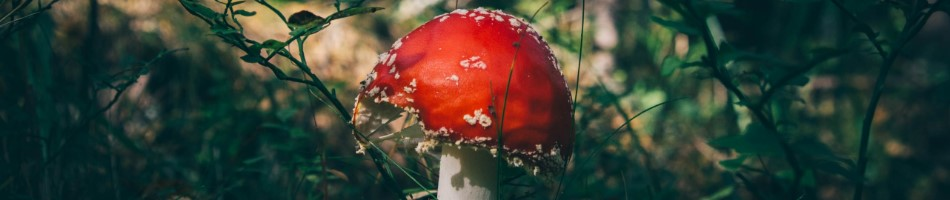

Veri kümesi 8124 mantardan veri içeriyor. Bu mantar örneklerinin her biri 22 özelliğe sahip ve yenilebilir veya zehirli olarak kategorilendiriliyor.🍄😋

### Verileri Setini Yükleme ve Okuma

.csv dosyasını okuyalım.

📌 Pandas kütüphanesinin read_csv() fonksiyonunu kullan.

In [16]:
from google.colab import files
uploaded = files.upload()

# Dosya adını ve yolunu belirtin
df = pd.read_csv('mushrooms.csv')

# İlk birkaç satırı görüntüleyin
df.head()


Saving mushrooms.csv to mushrooms (3).csv


class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

Şimdi, veri setini daha iyi anlamak için bazı görselleştirme tekniklerinden yararlanabiliriz. Örneğin, bir çubuk grafik oluşturarak farklı sınıfları karşılaştırabiliriz.

Sınıf başına örnek sayısını bulmakla başlayacağız.

📌 value_counts() yöntemini kullanın.

In [18]:
# Veri nesnesinin "class" sütununda value_counts metodunu kullanın

class_counts = df['class'].value_counts()

# Sonucu yazdır
print(class_counts)




class
e    4208
p    3916
Name: count, dtype: int64


Bu bilgilerle her sınıf için çubuklar oluşturabilir ve grafiği görüntüleyebiliriz.

📌 Grafiği oluşturmak için .bar() metodunu kullanın.

📌 plt.show() kullanmayı unutmayın.

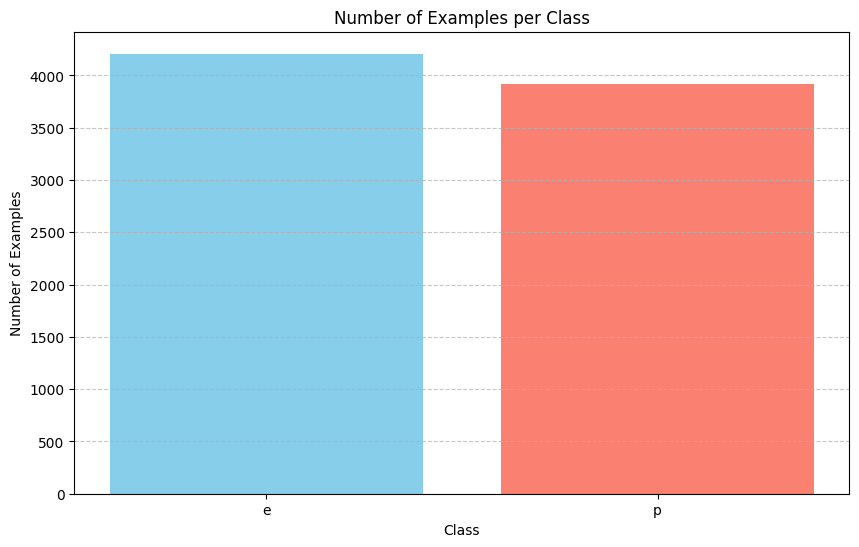

In [19]:
# Çubuk Grafiğini oluşturun
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])

# Başlık ve etiketleri ekleyin
plt.title('Number of Examples per Class')
plt.xlabel('Class')
plt.ylabel('Number of Examples')

# Daha iyi okunabilirlik için y ekseninde ızgara çizgileri ekleyin
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Grafiği gösterin
plt.show()


### Özellikler ve etiketler
Harika, verilerimizi daha iyi anladık. Şimdi onu özelliklere ve karşılık gelen etiketlere böleceğiz.

Bizim durumumuzda özellikler olarak "cap-shape", "cap-color", "ring-number" ve "ring-type" sütunlarını kullanacağız.

📌 X ve Y veri kümelerini oluşturmak için .loc() yöntemini kullanın.

In [23]:
# Özellikler (X) ve etiketler (y) için veri ayırma
X = df.loc[:, ['cap-shape', 'cap-color', 'ring-number', 'ring-type']]
y = df.loc[:, 'class']

# Sonuçları kontrol edin
print("Özellikler (X) ilk birkaç satır:")
print(X.head())

print("\nEtiketler (y) ilk birkaç satır:")
print(y.head())


Özellikler (X) ilk birkaç satır:
  cap-shape cap-color ring-number ring-type
0         x         n           o         p
1         x         y           o         p
2         b         w           o         p
3         x         w           o         p
4         x         g           o         e

Etiketler (y) ilk birkaç satır:
0    p
1    e
2    e
3    p
4    e
Name: class, dtype: object


###Değerleri dönüştürme

Değerler dize biçimindedir. Bunlarla matematiksel işlemler yapabilmek için bunları tam sayı değerlerine dönüştürmemiz gerekir. Bunun için etiket kodlamasını kullanacağız.

📌 X- verisinin birden fazla sütunu olduğundan, tüm sütunları aynı anda güncelleyebilmeniz için bunu bir for döngüsünde yapın.

📌 y verileri için doğrudan kodlayıcıyı kullanın.

In [26]:
from sklearn.preprocessing import LabelEncoder

# 1. Bir LabelEncoder nesnesi oluşturun
label_encoder = LabelEncoder()

# 2. Özellikleri bir for döngüsü içinde tam sayılara kodlayın
for column in X.columns:
    X[column] = label_encoder.fit_transform(X[column])

# 3. Çıktı etiketlerini tam sayılara kodlayın
y = label_encoder.fit_transform(y)


Son verileri görmek için hem X'i hem de y'yi yazdıralım.

In [27]:
# X ve y verilerini yazdırın
print("Özellikler (X):")
print(X.head())

print("\nEtiketler (y):")
print(y)


Özellikler (X):
   cap-shape  cap-color  ring-number  ring-type
0          5          4            1          4
1          5          9            1          4
2          0          8            1          4
3          5          8            1          4
4          5          3            1          0

Etiketler (y):
[1 0 0 ... 0 1 0]


### Verileri Bölün
Son olarak, verilerimizi eğitim ve test veri kümelerine bölebiliriz.

📌 sklearn'den train_test_split fonksiyonunu kullanın.

In [28]:
from sklearn.model_selection import train_test_split

# Eğitim ve test veri setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Sonuçları kontrol etmek için boyutlarını yazdırın
print(f"Eğitim seti - Özellikler: {X_train.shape}, Etiketler: {y_train.shape}")
print(f"Test seti - Özellikler: {X_test.shape}, Etiketler: {y_test.shape}")


Eğitim seti - Özellikler: (5686, 4), Etiketler: (5686,)
Test seti - Özellikler: (2438, 4), Etiketler: (2438,)


## Model Oluşturma Ve Eğitme

Verilerimiz kullanıma hazır! Modellerimizi karşılaştırma eğitimine geçelim.

Zaten içe aktardığımız modelleri kullanıyoruz.

📌 Modelleri oluşturmak için ilgili sınıf adlarını kullanın.

In [29]:
# Lojistik Regresyon modelini oluşturun
log_reg = LogisticRegression(max_iter=500)

# Ridge Sınıflandırıcı modelini oluşturun
ridge_clf = RidgeClassifier()

# Karar Ağacı Sınıflandırıcı modelini oluşturun
decision_tree = DecisionTreeClassifier()

# Gaussian Naive Bayes modelini oluşturun
gnb = GaussianNB()

# Çok Katmanlı Algılayıcı (MLP) modelini oluşturun
mlp = MLPClassifier(max_iter=500)


Daha sonra, oluşturduğumuz X_train ve y_train veri setiyle tüm modelleri eğitiyoruz.

📌 Her nesnenin .fit() metodunu kullanarak tüm modelleri eğitin.

In [30]:
# Lojistik Regresyon modelini eğit
log_reg.fit(X_train, y_train)

# Ridge Sınıflandırıcı modelini eğit
ridge_clf.fit(X_train, y_train)

# Karar Ağacı Sınıflandırıcı modelini eğit
decision_tree.fit(X_train, y_train)

# Gaussian Naive Bayes modelini eğit
gnb.fit(X_train, y_train)

# Çok Katmanlı Algılayıcı (MLP) modelini eğit
mlp.fit(X_train, y_train)


MLPClassifier(max_iter=500)

X_test setini kullanarak her modelle tahminler yaparız ve sonuçları ilgili değişkenlere kaydederiz.

📌 Her modelde .predict() metodunu kullanırız

In [31]:
# Lojistik Regresyon modelinde test veri setini kullanarak tahminde bulunuruz
log_reg_predictions = log_reg.predict(X_test)

# Ridge Sınıflandırıcı modelinde test veri setini kullanarak tahminde bulunuruz
ridge_clf_predictions = ridge_clf.predict(X_test)

# Karar Ağacı modelinde test veri setini kullanarak tahminde bulunuruz
decision_tree_predictions = decision_tree.predict(X_test)

# Gaussian Naive Bayes modelinde test veri setini kullanarak tahminde bulunuruz
gnb_predictions = gnb.predict(X_test)

# Çok Katmanlı Algılayıcı (MLP) modelinde test veri setini kullanarak tahminde bulunuruz
mlp_predictions = mlp.predict(X_test)


##Performansları karşılaştırma

Kesinlik, geri çağırma, f-1 puanı ve doğruluğu ayrı ayrı hesaplamak yerine performansları karşılaştırmak için bir rapor oluşturabiliriz.

📌 classification_report() fonksiyonu kullanmanız gereken fonksiyondur.

📌 Tüm modellerin sonuçlarını yazdırın

In [33]:
# Lojistik Regresyon modeli için bir Sınıflandırma Raporu Oluştur
log_reg_report = classification_report(y_test, log_reg_predictions)
print("Lojistik Regresyon Modeli Performans Raporu:\n", log_reg_report)

# Ridge Sınıflandırıcı modeli için bir Sınıflandırma Raporu Oluştur
ridge_clf_report = classification_report(y_test, ridge_clf_predictions)
print("Ridge Sınıflandırıcı Modeli Performans Raporu:\n", ridge_clf_report)

# Karar Ağacı modeli için bir Sınıflandırma Raporu Oluştur
decision_tree_report = classification_report(y_test, decision_tree_predictions)
print("Karar Ağacı Modeli Performans Raporu:\n", decision_tree_report)

# Gaussian Naive Bayes modeli için bir Sınıflandırma Raporu Oluştur
gnb_report = classification_report(y_test, gnb_predictions)
print("Gaussian Naive Bayes Modeli Performans Raporu:\n", gnb_report)

# Çok Katmanlı Algılayıcı (MLP) modeli için bir Sınıflandırma Raporu Oluştur
mlp_report = classification_report(y_test, mlp_predictions)
print("MLP Modeli Performans Raporu:\n", mlp_report)


Lojistik Regresyon Modeli Performans Raporu:
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      1257
           1       0.78      0.78      0.78      1181

    accuracy                           0.79      2438
   macro avg       0.79      0.79      0.79      2438
weighted avg       0.79      0.79      0.79      2438

Ridge Sınıflandırıcı Modeli Performans Raporu:
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      1257
           1       0.78      0.78      0.78      1181

    accuracy                           0.79      2438
   macro avg       0.79      0.79      0.79      2438
weighted avg       0.79      0.79      0.79      2438

Karar Ağacı Modeli Performans Raporu:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      1257
           1       0.88      0.91      0.89      1181

    accuracy                           0.89      

##Değerlendirme
Karar ağacı en iyi performansı gösterdi. Bu yüzden belki de işleri bir adım öteye götürüp Rastgele Orman algoritmasını deneyip daha iyi çalışıp çalışmadığını görebiliriz.

📌 Aynı adımları izleyin ve Rastgele Orman için sınıflandırma raporunu yazdırın

In [34]:

# 1. Random Forest Sınıflandırıcı nesnesini oluşturun
random_forest = RandomForestClassifier()

# 2. Modeli eğitim veri seti ile eğitin
random_forest.fit(X_train, y_train)

# 3. Test veri seti üzerinde tahminler yapın
rf_predictions = random_forest.predict(X_test)

# 4. Sınıflandırma raporunu oluşturun ve yazdırın
print("Random Forest Modeli için Sınıflandırma Raporu:\n")
print(classification_report(y_test, rf_predictions))


Random Forest Modeli için Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1257
           1       0.88      0.91      0.89      1181

    accuracy                           0.89      2438
   macro avg       0.90      0.90      0.89      2438
weighted avg       0.90      0.89      0.90      2438

